<a href="https://colab.research.google.com/github/data-aleks/billboard_hot100_tidytuesday_26_08_2025/blob/main/tidy_tuesday_26082025_billboard_hot_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install musicbrainzngs

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import musicbrainzngs
import time
from datetime import datetime
import math

# **Billboard Hot 100 Number Ones - Tidy Tuesday - 26.08.2025**

This week we are exploring the Billboard Hot 100 Number Ones Database. This workbook contains substantial data about every song to ever top the Billboard Hot 100 between August 4, 1958 and January 11, 2025. It was compiled by Chris Dalla Riva as he wrote the book Uncharted Territory: What Numbers Tell Us about the Biggest Hit Songs and Ourselves. It also often powers his newsletter Can't Get Much Higher.

7 years ago, I decided that I was going to listen to every number one hit. Along the way, I tracked an absurd amount of information about each song. Using that information, I wrote a data-driven history of popular music covering 1958 through today.

- Have #1 hits become shorter over time?
- Does the relation between artist age and chart success change across time?
- Which keys are most common in #1 hits? Do our key preferences differ by genre?
- What lyrical topics have dominated #1 hits across different decades?
- How has the prevalence of explicit content changed over time?

Thank you to Jen Richmond (R-Ladies Sydney) for curating this week's dataset.

In [3]:
df_billboard = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-08-26/billboard.csv')
df_topics = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-08-26/topics.csv')


In [4]:
if df_billboard.empty or df_topics.empty:
  print('Couldnt get the data')
else:
  print('Data loaded succesfully')

Data loaded succesfully


## **Step 1.** Exploring dataset

In this step we will look at our dataframe, see if there is missing values and decide how we will approach cleaning the dataset to be used in future steps.

In [5]:
df_billboard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Columns: 105 entries, song to u_s_artwork
dtypes: float64(17), int64(61), object(27)
memory usage: 965.6+ KB


In [6]:
df_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   lyrical_topics  97 non-null     object
dtypes: object(1)
memory usage: 908.0+ bytes


This is very wide dataset, the best way to check for missing values would be to show us the columns that have more than 0 missing values.

In [7]:
missing_counts = df_billboard.isnull().sum()
missing_counts[missing_counts > 0].sort_values(ascending=False)

,0
featured_in_a_then_contemporary_play,1175
talent_contestant,1167
double_a_side,1165
featured_in_a_then_contemporary_t_v_show,1152
sound_effects,1113
featured_in_a_then_contemporary_film,1073
featured_artists,988
discogs_style,94
cdr_style,88
cdr_genre,88


As we can see here, this is a very wide dataset with some columns missing quite a few of the values. At this stage we need to decide how to approach this? Is working with 100+ columns optimal not only from analysis perspective but also from performance perspective. We can't even view the entire 100+ columns using standard .info() , i think the best way to work with this dataset is to only use what we need to answer our questions. This will benefit overall technical perforamnce, but will also make working with the dataset easier.

## **Step 2.** Cleaning dataset

This is a very wide datset, with over 100 columns of data. While i would love to utilise every single column of data and use the entirety of this dataset i think the best approach would be to extract selected columns in to a new dataframe to make working with this data easier. We could always add extra columns if neccesary. This will prevent us from carrying out unnecessary data cleaning steps, again if there is need for any extra columns that have missing values we could always add these if needed. Initially i will extract the data required to deal with the initial questions.

### **Step 2.1** Extracting data required for our analysis

* 'Have #1 hits become shorter over time' for this question we will need date the record is released and it's length in seconds.
* 'Does the relation between artist age and chart success change across time?' we will need front_person_age
* 'Which keys are most common in #1 hits? Do our key preferences differ by genre?' we will need song key information, luckily we have both key and simplified_key information, i think simplified key will serve us best as we need to know general key of the record.
* 'What lyrical topics have dominated #1 hits across different decades?' this is simple again, we will only require lyrical_topic column
* 'How has the prevalence of explicit content changed over time?' we have a column which identifies records that have explicit content.

In [8]:
df_billboard_short = df_billboard[['date', 'artist', 'front_person_age', 'song', 'discogs_genre', 'cdr_genre', 'length_sec', 'simplified_key', 'lyrical_topic',  'explicit']]

In [9]:
df_billboard_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1177 non-null   object 
 1   artist            1177 non-null   object 
 2   front_person_age  1155 non-null   float64
 3   song              1177 non-null   object 
 4   discogs_genre     1161 non-null   object 
 5   cdr_genre         1089 non-null   object 
 6   length_sec        1177 non-null   int64  
 7   simplified_key    1177 non-null   object 
 8   lyrical_topic     1151 non-null   object 
 9   explicit          1177 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 92.1+ KB


In [10]:
df_billboard_short.head()

,date,artist,front_person_age,song,discogs_genre,cdr_genre,length_sec,simplified_key,lyrical_topic,explicit
0,1958-08-04T00:00:00Z,Ricky Nelson,18.0,Poor Little Fool,Rock,Pop;Rock,154,C,Lost Love,0
1,1958-08-18T00:00:00Z,Domenico Modugno,30.0,Nel Blu Dipinto Di Blu,"Pop;Folk, World, & Country",Pop,219,Bb,Flying;Dreaming,0
2,1958-08-25T00:00:00Z,The Elegants,17.0,Little Star,Rock,Rock,163,A,Longing for Love,0
3,1958-09-29T00:00:00Z,Tommy Edwards,35.0,It's All in the Game,Rock;Pop,Pop,156,Eb,Love,0
4,1958-11-10T00:00:00Z,Conway Twitty,25.0,It's Only Make Believe,Rock,Pop,134,B,Lost Love,0


Now we have a very condensed dataset containing only data we need to answer the questions we need to answer.

### **Step 2.2** Dealing with missing values in the dataset.

The dataset still has some missing values, which i do not like. The total number of rows with missing data is approximately 48 which would represent around 4.1 % of our data. There is a couple of way we are able to approach this. We could potentially attempt to fill the missing data but give the low number of rows affected i think the most simplest approach would be to remove rows with missing values as it's below 5% of our entire data and would not affect our analysis.

In [11]:
df_billboard_short[df_billboard_short['front_person_age'].isnull()]

,date,artist,front_person_age,song,discogs_genre,cdr_genre,length_sec,simplified_key,lyrical_topic,explicit
47,1961-04-03T00:00:00Z,The Marcels,NaN,Blue Moon,Rock,Rock,135,G,Longing for Love;Love,0
62,1961-12-18T00:00:00Z,The Tokens,NaN,The Lion Sleeps Tonight,Rock,Pop,162,F,Unclear,0
81,1962-12-22T00:00:00Z,The Tornados,NaN,Telstar,Rock,Rock,195,Multiple Keys,NaN,0
94,1963-08-03T00:00:00Z,The Tymes,NaN,So Much in Love,Funk/Soul,Funk/Soul,140,E,Love,0
192,1967-11-25T00:00:00Z,Strawberry Alarm Clock,NaN,Incense and Peppermints,Rock,Rock,167,G,Utopia/Perfect Places;Love;Coexistence,0
218,1969-09-20T00:00:00Z,The Archies,NaN,"Sugar, Sugar",Rock;Pop,Pop,168,D,Love,0
253,1971-06-12T00:00:00Z,Honey Cone,NaN,Want Ads,Funk/Soul,Funk/Soul,166,Ab,Longing for Love;Bad Relationships,0
323,1974-04-20T00:00:00Z,MFSB,NaN,TSOP (The Sound of Philadelphia),Funk/Soul;Pop,Funk/Soul,212,C,NaN,0
327,1974-06-15T00:00:00Z,Bo Donaldson & the Heywoods,NaN,Billy Don't Be a Hero,Rock,Rock,207,Bb,Love;Death;War,0
352,1975-02-08T00:00:00Z,Ohio Players,NaN,Fire,Funk/Soul,Funk/Soul,192,Cm,Lust/Sex,0


In [12]:
df_billboard_short[df_billboard_short['lyrical_topic'].isnull()]

,date,artist,front_person_age,song,discogs_genre,cdr_genre,length_sec,simplified_key,lyrical_topic,explicit
12,1959-05-11T00:00:00Z,"Dave ""Baby"" Cortez",20.0,The Happy Organ,Rock,Rock,122,Db,NaN,0
18,1959-09-21T00:00:00Z,Santo & Johnny,19.5,Sleep Walk,Jazz;Rock;Pop,Rock,151,C,NaN,0
26,1960-02-22T00:00:00Z,Percy Faith & His Orchestra,51.0,Theme from A Summer Place,Pop;Stage & Screen,Pop,144,Multiple Keys,NaN,0
42,1961-01-09T00:00:00Z,Bert Kaempfert,37.0,Wonderland by Night,Jazz;Blues;Stage & Screen,Pop,194,Eb,NaN,0
44,1961-02-13T00:00:00Z,Lawrence Welk,57.0,Calcutta,Pop,Pop,136,G,NaN,0
70,1962-05-26T00:00:00Z,Mr. Acker Bilk,33.0,Stranger on the Shore,Jazz;Stage & Screen,Pop,172,Eb,NaN,0
72,1962-07-07T00:00:00Z,David Rose & His Orchestra,52.0,The Stripper,Pop,Jazz,116,F,NaN,0
81,1962-12-22T00:00:00Z,The Tornados,NaN,Telstar,Rock,Rock,195,Multiple Keys,NaN,0
95,1963-08-10T00:00:00Z,Stevie Wonder,13.0,Fingertips Pt. 2,Funk/Soul,Funk/Soul;Jazz,190,Cm,NaN,0
197,1968-02-10T00:00:00Z,Paul Mauriat,42.0,Love is Blue,Pop,Pop,151,Multiple Keys,NaN,0


In [13]:
df_billboard_short[df_billboard_short['discogs_genre'].isnull()]

,date,artist,front_person_age,song,discogs_genre,cdr_genre,length_sec,simplified_key,lyrical_topic,explicit
1095,2020-01-18T00:00:00Z,Roddy Ricch,21.000000,The Box,NaN,NaN,196,Bbm,Bragging;Violence;Lust/Sex,1
1103,2020-06-13T00:00:00Z,DaBaby ft. Roddy Ricch,24.500000,ROCKSTAR,NaN,NaN,181,Abm,Death;Violence;Bragging;Murder,1
1118,2021-04-03T00:00:00Z,Justin Bieber ft. Daniel Caeser & Giveon,27.000000,Peaches,NaN,NaN,198,C,Longing for Love;Love,1
1127,2021-09-18T00:00:00Z,Drake ft. Future & Young Thug,34.000000,Way 2 Sexy,NaN,NaN,257,Em,Lust/Sex;Bragging,1
1135,2022-04-23T00:00:00Z,Jack Harlow,24.000000,First Class,NaN,NaN,173,Gm,Bragging;Lust/Sex;Dreaming;Fame;Resilience;Mat...,1
1136,2022-05-14T00:00:00Z,Future ft. Drake & Tems,33.333333,WAIT 4 U,NaN,NaN,189,Db,Longing for Love;Lost Love,1
1137,2022-07-02T00:00:00Z,Drake ft. 21 Savage,32.000000,Jimmy Cooks,NaN,NaN,218,Multiple Keys,Lust/Sex;Bragging,1
1146,2023-03-18T00:00:00Z,Morgan Wallen,29.000000,Last Night,NaN,NaN,163,Gb,Lost Love;Bad Relationships,1
1147,2023-04-08T00:00:00Z,Jimin,27.000000,Like Crazy,NaN,NaN,212,Dm,Fame;Paranoia,0
1153,2023-09-09T00:00:00Z,Zach Bryan ft. Kacey Musgraves,31.000000,I Remember Everything,NaN,NaN,227,C,Lost Love;Escape;Better Times;Regret,0


In [14]:
df_billboard_short[df_billboard_short['cdr_genre'].isnull()]

,date,artist,front_person_age,song,discogs_genre,cdr_genre,length_sec,simplified_key,lyrical_topic,explicit
1089,2019-10-19T00:00:00Z,Travis Scott,28.0,HIGHEST IN THE ROOM,Hip Hop,NaN,175,Dm,Partying;Lust/Sex,1
1090,2019-11-02T00:00:00Z,Lewis Capaldi,23.0,Someone You Loved,Rock;Pop,NaN,182,Db,Lost Love,0
1091,2019-11-09T00:00:00Z,Selena Gomez,27.0,Lose You to Love Me,Pop,NaN,206,E,Lost Love,0
1092,2019-11-30T00:00:00Z,Post Malone,24.0,Circles,Rock,NaN,215,C,Lost Love;Bad Relationships,1
1093,2019-12-14T00:00:00Z,The Weeknd,29.0,Heartless,Pop,NaN,198,Bbm,Lust/Sex;Addicition,1
...,...,...,...,...,...,...,...,...,...,...
1172,2024-06-29T00:00:00Z,Sabrina Carpenter,25.0,Please Please Please,Pop,NaN,186,Multiple Keys,Love;Restlessness,1
1173,2024-07-13T00:00:00Z,Shaboozey,29.0,A Bar Song (Tipsy),"Hip Hop;Folk, World, & Country",NaN,171,A,Partying;Dancing,1
1174,2024-11-02T00:00:00Z,Morgan Wallen,31.0,Love Somebody,NaN,NaN,204,Fm,Lost Love;Longing for Love,0
1175,2024-12-07T00:00:00Z,Kendrick Lamar,37.0,squabble up,NaN,NaN,157,Fm,Bragging,1


In [15]:
missing_in_cdr_only = df_billboard_short['discogs_genre'].isnull() & df_billboard_short['cdr_genre'].notnull()

num_missing_in_cdr_only = missing_in_cdr_only.sum()

print(f"Number of rows with 'cdr_genre' data but missing 'discogs_genre' data: {num_missing_in_cdr_only}")

Number of rows with 'cdr_genre' data but missing 'discogs_genre' data: 0


In [16]:
df_billboard_short = df_billboard_short.drop(['cdr_genre'], axis=1)

In [17]:
# Set your user agent (required by MusicBrainz)
musicbrainzngs.set_useragent("Your_App_Name", "1.0", "your_email@example.com")

# Make a copy to avoid modifying the original DataFrame
# This is the first step to prevent a SettingWithCopyWarning
df_imputed = df_billboard_short.copy()

# Find the indices of rows with missing 'discogs_genre'
missing_indices = df_imputed[df_imputed['discogs_genre'].isnull()].index

print(f"Attempting to fill {len(missing_indices)} missing genre values using a fallback strategy...")

# Iterate over the rows with missing values
for index in missing_indices:
    artist = df_imputed.loc[index, 'artist']
    song = df_imputed.loc[index, 'song']

    try:
        # Step 1: Search for a recording (song) and get tags
        result = musicbrainzngs.search_recordings(artist=artist, recording=song, limit=1)
        if result['recording-list'] and 'tag-list' in result['recording-list'][0] and result['recording-list'][0]['tag-list']:
            genre = result['recording-list'][0]['tag-list'][0]['name']
            # Correctly assign the value using .loc
            df_imputed.loc[index, 'discogs_genre'] = genre
            print(f"Filled genre for '{song}' by '{artist}' with '{genre}' (via recording).")
            continue # Move to the next iteration if a genre was found

        # Step 2: If no genre found for the recording, search for the artist's genre
        artist_result = musicbrainzngs.search_artists(artist=artist, limit=1)
        if artist_result['artist-list'] and 'tag-list' in artist_result['artist-list'][0] and artist_result['artist-list'][0]['tag-list']:
            genre = artist_result['artist-list'][0]['tag-list'][0]['name']
            # Correctly assign the value using .loc
            df_imputed.loc[index, 'discogs_genre'] = genre
            print(f"Filled genre for '{song}' by '{artist}' with '{genre}' (via artist).")
        else:
            print(f"No genre tags found for '{song}' by '{artist}'.")

    except Exception as e:
        print(f"MusicBrainz API request failed for '{song}' by '{artist}': {e}")

    # Sleep to respect API rate limits (1 request per second)
    time.sleep(1.0)

# Final step: Fill any remaining missing genres with 'Unknown'
# Corrected line to avoid FutureWarning
df_imputed['discogs_genre'] = df_imputed['discogs_genre'].fillna('Unknown')
print("\nImputation complete. All remaining missing values have been filled with 'Unknown'.")

Attempting to fill 16 missing genre values using a fallback strategy...
Filled genre for 'The Box' by 'Roddy Ricch' with 'english' (via artist).
Filled genre for 'ROCKSTAR' by 'DaBaby ft. Roddy Ricch' with 'english' (via artist).
Filled genre for 'Peaches' by 'Justin Bieber ft. Daniel Caeser & Giveon' with 'pop' (via artist).
Filled genre for 'Way 2 Sexy' by 'Drake ft. Future & Young Thug' with 'rock' (via artist).
Filled genre for 'First Class' by 'Jack Harlow' with 'hip hop' (via artist).
Filled genre for 'WAIT 4 U' by 'Future ft. Drake & Tems' with 'pop' (via artist).
Filled genre for 'Jimmy Cooks' by 'Drake ft. 21 Savage' with 'hip hop' (via artist).
Filled genre for 'Last Night' by 'Morgan Wallen' with 'country' (via recording).
Filled genre for 'Like Crazy' by 'Jimin' with 'pop' (via artist).
Filled genre for 'I Remember Everything' by 'Zach Bryan ft. Kacey Musgraves' with 'pop' (via recording).
Filled genre for 'First Person Shooter' by 'Drake ft. J Cole' with 'terf' (via artist

In [18]:
def clean_genre(genre_string):
    """
    Cleans and standardizes a single genre entry.
    """
    if not isinstance(genre_string, str):
        return 'Unknown' # Handle non-string or missing values

    # Convert to lowercase and handle common variations
    genre_string = genre_string.lower().strip().replace(' / ', '/')

    # Split into individual genres if there are multiple
    genres = genre_string.split(';')

    # Define a simplified genre mapping
    genre_mapping = {
        'rock': 'Rock',
        'pop': 'Pop',
        'folk': 'Folk',
        'country': 'Country',
        'jazz': 'Jazz',
        'blues': 'Blues',
        'hip hop': 'Hip Hop',
        'hiphop': 'Hip Hop', # Handle variations
        'funk': 'Funk/Soul',
        'soul': 'Funk/Soul',
        'electronic': 'Electronic',
        'reggae': 'Reggae',
        'latin': 'Latin',
        'stage & screen': 'Stage & Screen'
    }

    # Find the first matching genre
    for genre in genres:
        for keyword, mapped_genre in genre_mapping.items():
            if keyword in genre:
                return mapped_genre

    # If no match is found, return 'Other'
    return 'Other'


In [19]:
df_billboard_short['discogs_genre'].unique()

array(['Rock', 'Pop;Folk, World, & Country', 'Rock;Pop',
       'Folk, World, & Country', 'Pop', "Pop;Children's", 'Funk/Soul',
       'Jazz;Rock;Pop', 'Pop;Stage & Screen',
       'Rock;Pop;Folk, World, & Country',
       'Funk/Soul;Blues;Pop;Folk, World, & Country',
       'Jazz;Blues;Stage & Screen', 'Rock;Funk/Soul', 'Rock;Blues',
       'Funk/Soul;Pop', 'Rock;Funk/Soul;Pop', 'Jazz;Stage & Screen',
       'Rock;Folk, World, & Country', 'Funk/Soul;Blues;Pop', 'Jazz;Pop',
       'Funk/Soul;Blues;Folk, World, & Country',
       'Rock;Pop;Stage & Screen', 'Funk/Soul;Stage & Screen', 'Jazz;Rock',
       'Reggae;Funk/Soul', 'Funk/Soul;Folk, World, & Country',
       'Electronic;Funk/Soul', 'Rock;Stage & Screen', 'Electronic',
       'Electronic;Stage & Screen', 'Electronic;Rock;Funk/Soul;Pop',
       'Jazz;Funk/Soul', 'Rock;Reggae',
       'Rock;Pop;Folk, World, & Country;Stage & Screen',
       'Electronic;Rock', 'Electronic;Classical;Stage & Screen',
       'Electronic;Pop', 'Electroni

In [20]:
df_imputed['discogs_genre_cleaned'] = df_imputed['discogs_genre'].apply(clean_genre)

In [21]:
print(df_imputed['discogs_genre_cleaned'].unique())

['Rock' 'Pop' 'Folk' 'Funk/Soul' 'Jazz' 'Reggae' 'Electronic' 'Hip Hop'
 'Latin' 'Other' 'Stage & Screen' 'Country']


In [22]:
df_imputed[df_imputed['discogs_genre_cleaned'] == 'Other']

,date,artist,front_person_age,song,discogs_genre,length_sec,simplified_key,lyrical_topic,explicit,discogs_genre_cleaned
1095,2020-01-18T00:00:00Z,Roddy Ricch,21.0,The Box,english,196,Bbm,Bragging;Violence;Lust/Sex,1,Other
1103,2020-06-13T00:00:00Z,DaBaby ft. Roddy Ricch,24.5,ROCKSTAR,english,181,Abm,Death;Violence;Bragging;Murder,1,Other
1156,2023-10-21T00:00:00Z,Drake ft. J Cole,37.0,First Person Shooter,terf,247,Bm,Bragging;Fame,1,Other


In [23]:
df_billboard_short = df_imputed.dropna()

In [24]:
df_billboard_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 0 to 1176
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1132 non-null   object 
 1   artist                 1132 non-null   object 
 2   front_person_age       1132 non-null   float64
 3   song                   1132 non-null   object 
 4   discogs_genre          1132 non-null   object 
 5   length_sec             1132 non-null   int64  
 6   simplified_key         1132 non-null   object 
 7   lyrical_topic          1132 non-null   object 
 8   explicit               1132 non-null   int64  
 9   discogs_genre_cleaned  1132 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 97.3+ KB


In [25]:
df_billboard_short.head()

,date,artist,front_person_age,song,discogs_genre,length_sec,simplified_key,lyrical_topic,explicit,discogs_genre_cleaned
0,1958-08-04T00:00:00Z,Ricky Nelson,18.0,Poor Little Fool,Rock,154,C,Lost Love,0,Rock
1,1958-08-18T00:00:00Z,Domenico Modugno,30.0,Nel Blu Dipinto Di Blu,"Pop;Folk, World, & Country",219,Bb,Flying;Dreaming,0,Pop
2,1958-08-25T00:00:00Z,The Elegants,17.0,Little Star,Rock,163,A,Longing for Love,0,Rock
3,1958-09-29T00:00:00Z,Tommy Edwards,35.0,It's All in the Game,Rock;Pop,156,Eb,Love,0,Rock
4,1958-11-10T00:00:00Z,Conway Twitty,25.0,It's Only Make Believe,Rock,134,B,Lost Love,0,Rock


Lets convert our date column to datetime, add year column and remove records that are from year 2025 as ther is only 1 record in the data.

In [26]:
df_billboard_short = df_billboard_short.copy()

df_billboard_short['date'] = pd.to_datetime(df_billboard_short['date'])
df_billboard_short['year'] = df_billboard_short['date'].dt.year

In [27]:
df_billboard_short[df_billboard_short['year'] == 2025]

,date,artist,front_person_age,song,discogs_genre,length_sec,simplified_key,lyrical_topic,explicit,discogs_genre_cleaned,year
1176,2025-01-11 00:00:00+00:00,Bruno Mars & Lady Gaga,38.5,Die with a Smile,Pop,251,A,Love;Death;Longing for Love,0,Pop,2025


In [28]:
df_billboard_short = df_billboard_short[df_billboard_short['year'] != 2025]

Lets see how muchd data we have lost

In [29]:
original_rows = len(df_billboard)
cleaned_rows = len(df_billboard_short)

In [30]:
data_loss_percentage = ((original_rows - cleaned_rows) / original_rows) * 100

In [31]:
print(f"Original number of rows: {original_rows}")
print(f"Cleaned number of rows: {cleaned_rows}")
print(f"Data loss percentage: {data_loss_percentage:.2f}%")

Original number of rows: 1177
Cleaned number of rows: 1131
Data loss percentage: 3.91%


In [32]:
df_cleaned = df_billboard_short.copy()

## **Step 3.** Exploring Data Using Visualisations

### **Step 3.1** Have #1 hits become shorter over time?.

In [33]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 1175
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   date                   1131 non-null   datetime64[ns, UTC]
 1   artist                 1131 non-null   object             
 2   front_person_age       1131 non-null   float64            
 3   song                   1131 non-null   object             
 4   discogs_genre          1131 non-null   object             
 5   length_sec             1131 non-null   int64              
 6   simplified_key         1131 non-null   object             
 7   lyrical_topic          1131 non-null   object             
 8   explicit               1131 non-null   int64              
 9   discogs_genre_cleaned  1131 non-null   object             
 10  year                   1131 non-null   int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(2), ob

Lets remove records that match year 2025 as there is only 1 row of records in this year.

In [34]:
average_length_per_year = df_cleaned.groupby('year')['length_sec'].mean()

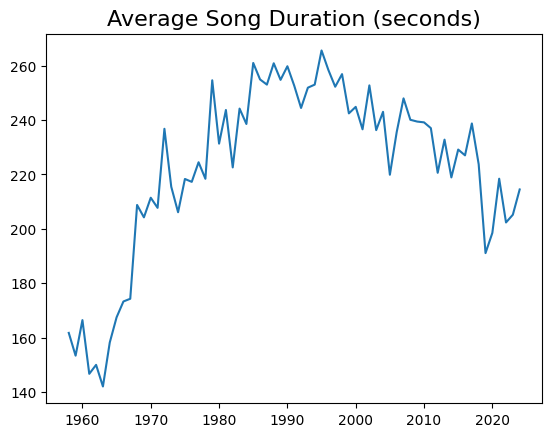

In [46]:
plt.plot(average_length_per_year.index, average_length_per_year.values)
plt.title('Average Song Duration (seconds)', fontsize=16)
plt.savefig('average_song_duration_seconds.png')

### **Step 3.2** Does the relation between artist age and chart success change across time?

In [36]:
average_age_per_year = df_cleaned.groupby('year')['front_person_age'].mean()

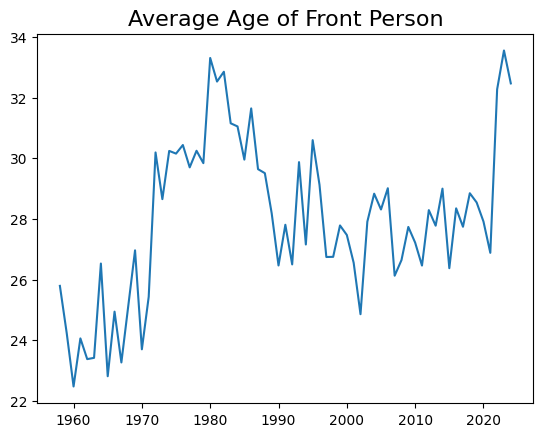

In [37]:
plt.plot(average_age_per_year.index, average_age_per_year.values)
plt.title('Average Age of Front Person', fontsize=16)
plt.savefig('average_front_person_age.png')

### **Step 3.3** Which keys are most common in #1 hits? Do our key preferences differ by genre?

In [38]:
key_counts = df_cleaned['simplified_key'].value_counts()

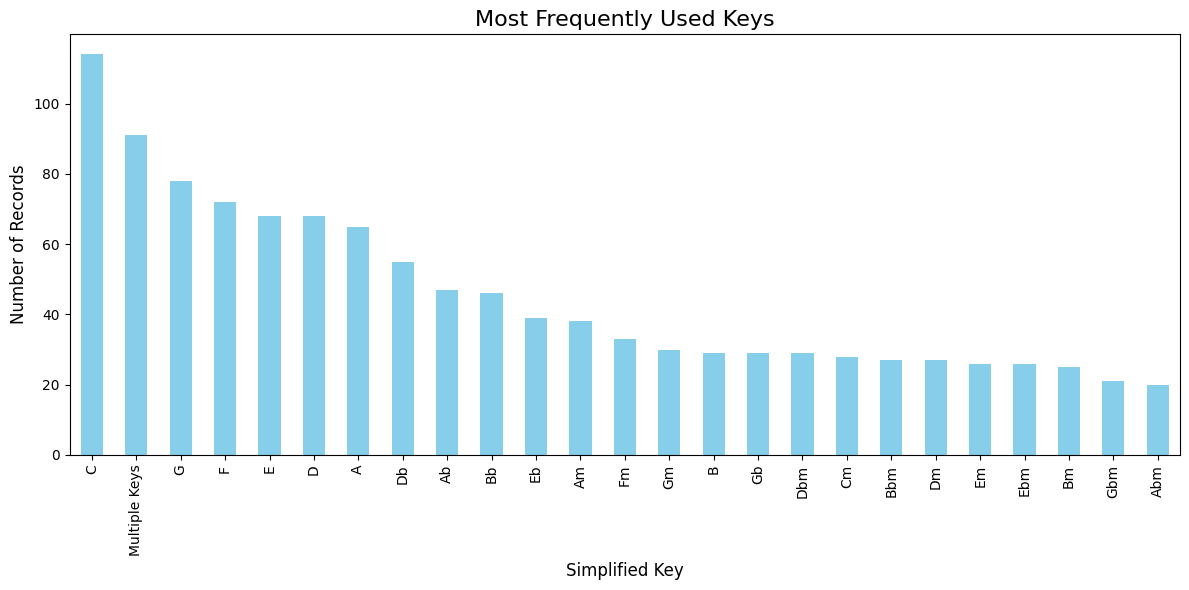

In [39]:
plt.figure(figsize=(12, 6))
key_counts.plot(kind='bar', color='skyblue')
plt.title('Most Frequently Used Keys', fontsize=16)
plt.xlabel('Simplified Key', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.savefig('most_frequently_used_keys.png')
plt.tight_layout()

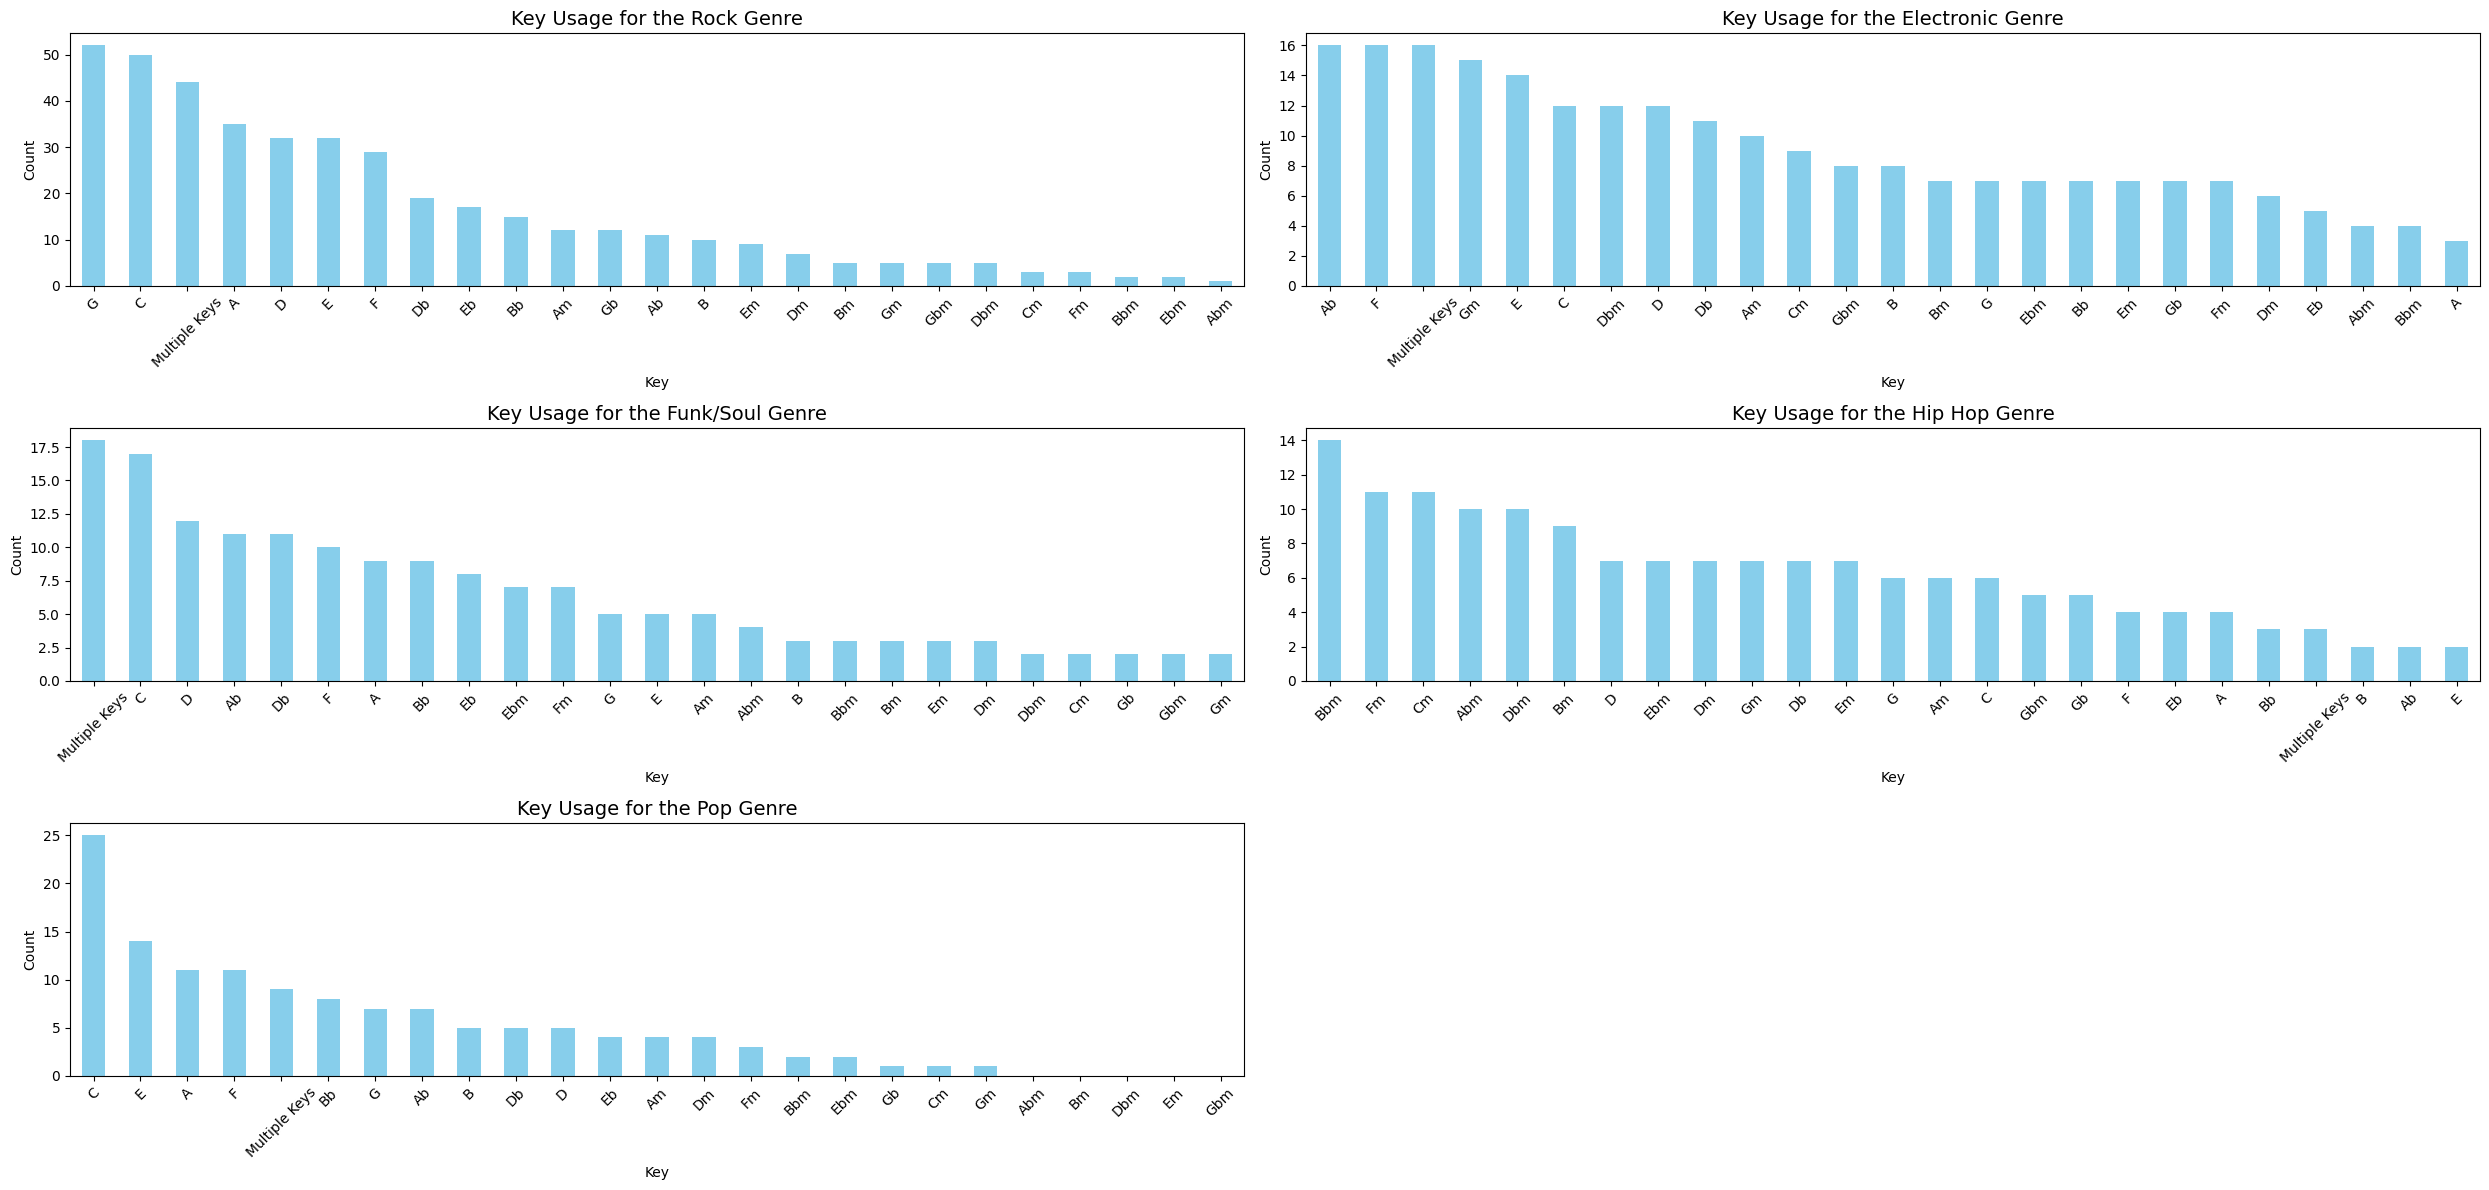

In [40]:
# Group by the cleaned genre and then get the value counts for keys
genre_key_counts = df_cleaned.groupby('discogs_genre_cleaned')['simplified_key'].value_counts().unstack(fill_value=0)

# Get the top N genres to make the plot readable (e.g., top 5)
top_genres = genre_key_counts.sum(axis=1).nlargest(5).index

# Calculate the number of rows needed for the grid (3 columns per row).
num_genres = len(top_genres)
num_rows = math.ceil(num_genres / 2)
num_cols = 2

# Create a single figure with a grid of subplots to hold all the bar charts.
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 4 * num_rows))

# Flatten the axs array to easily iterate over it, regardless of the number of rows.
axs = axs.flatten()

# Loop through each top genre with an index to place each chart in the correct subplot.
for i, genre in enumerate(top_genres):
    # Select the correct subplot from the grid for the current genre.
    ax = axs[i]

    # Sort the key counts for the current genre in descending order to make the plot readable.
    genre_data = genre_key_counts.loc[genre].sort_values(ascending=False)

    # Plot a bar chart on the current subplot.
    genre_data.plot(kind='bar', ax=ax, color='skyblue')

    # Add titles and labels for the current subplot.
    ax.set_title(f'Key Usage for the {genre} Genre', fontsize=14)
    ax.set_xlabel('Key')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplots if the total number of genres is not a multiple of 3.
for j in range(num_genres, len(axs)):
    fig.delaxes(axs[j])

# Adjust the layout to make sure labels and titles are not cut off.
plt.tight_layout()

# Save the entire figure with all plots to a file.
plt.savefig('genre_key_usage.png')

# Display the plot.
plt.show()

### **Step 4.4** What lyrical topics have dominated #1 hits across different decades?

In [41]:
def get_decade(year: int) -> str:
    """
    Calculates the decade string for a given year.

    Args:
        year: The year as an integer.

    Returns:
        The decade as a string (e.g., "1990s").
    """
    decade_start = (year // 10) * 10
    return f"{decade_start}"


In [42]:
df_cleaned['decade'] = df_cleaned['year'].apply(get_decade)

In [43]:
# Split lyrical_topic strings by semicolon, create an expanded version of existing dataset, filter dataframe from our df_topics.
# Group data by decade and lyrical topic and count occurances.
list_of_topics = df_topics['lyrical_topics'].unique()

df_cleaned['lyrical_topic_split'] = df_cleaned['lyrical_topic'].str.split(';')

df_exploded = df_cleaned.explode('lyrical_topic_split')

df_filtered = df_exploded[df_exploded['lyrical_topic'].isin(list_of_topics)]

topic_counts_per_decade = df_filtered.groupby(['decade', 'lyrical_topic']).size()

# Reshape the data for a clearer, table-like output using unstack.
topic_counts_per_decade_df = topic_counts_per_decade.unstack(fill_value=0)

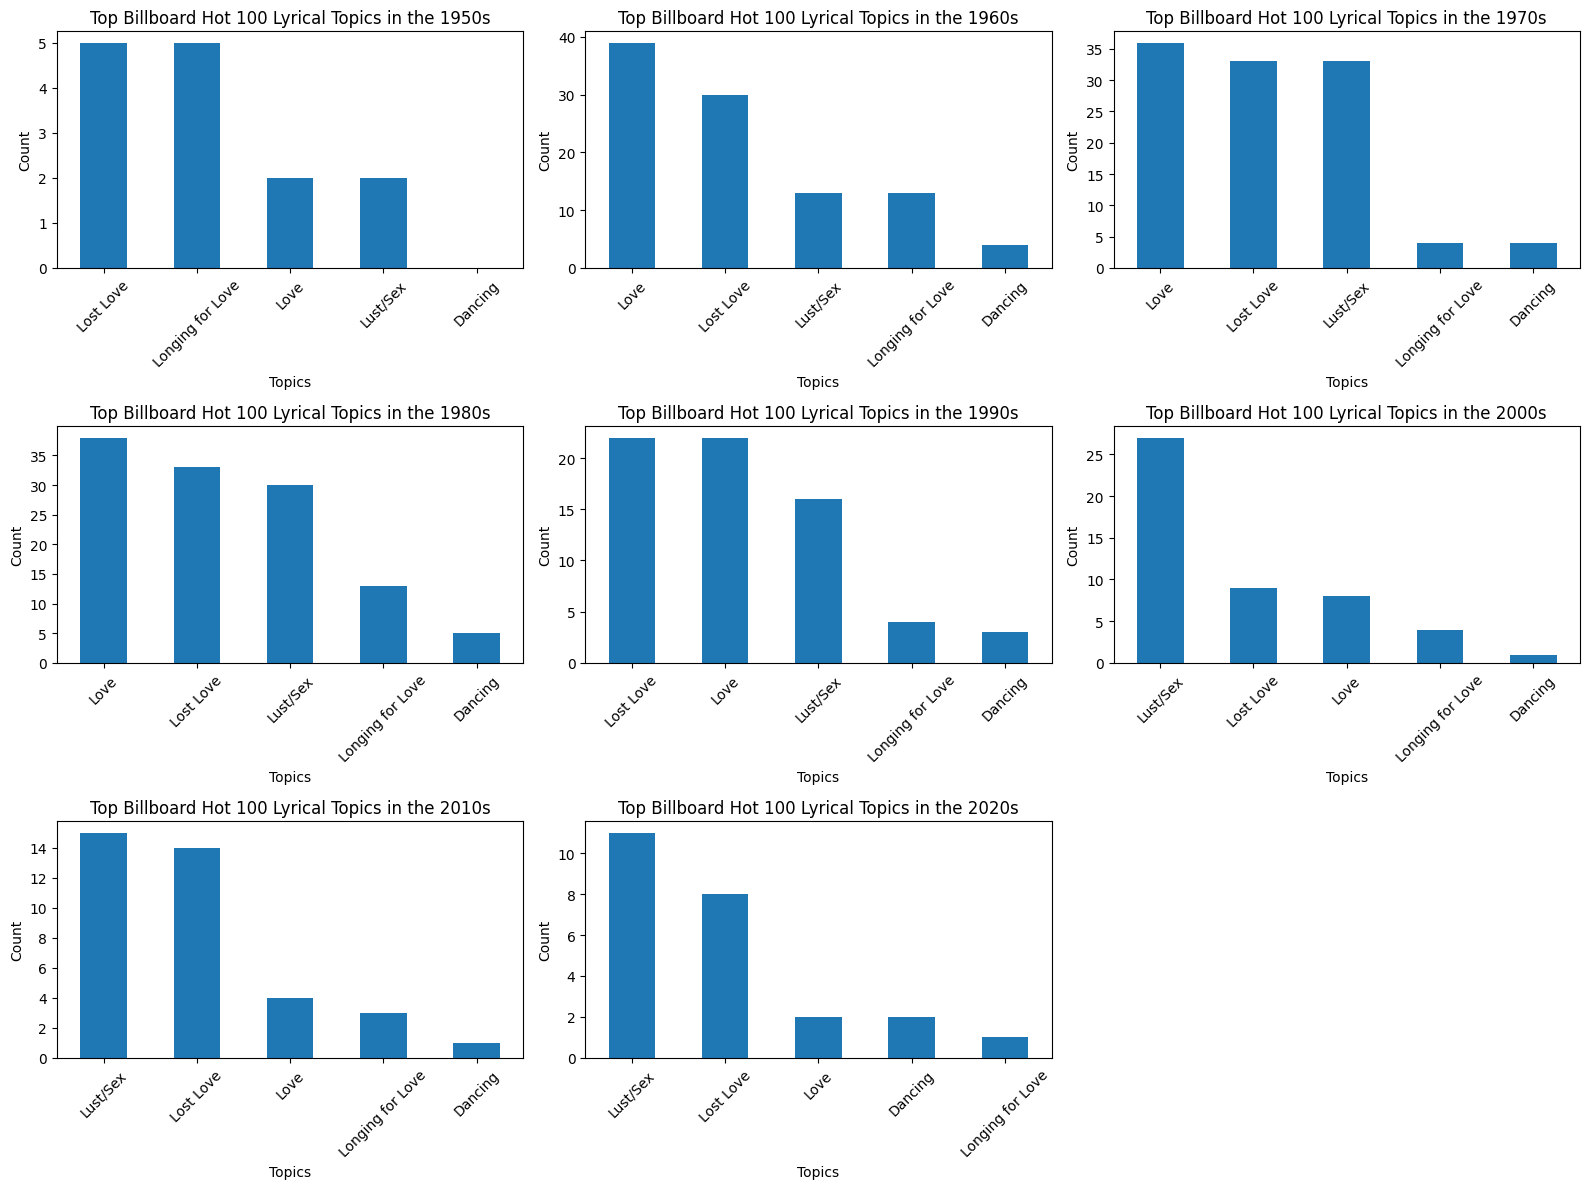

In [44]:
topics_with_occurrences = topic_counts_per_decade_df.sum() > 0

topic_counts_per_decade_df = topic_counts_per_decade_df.loc[:, topics_with_occurrences]
# Calculate the total count for each topic across all decades.
total_topic_counts = topic_counts_per_decade_df.sum(axis=0)

# Get the top 10 topics by count.
top_5_topics = total_topic_counts.nlargest(5).index

# Filter the DataFrame to include only the top 10 topics.
top_5_df = topic_counts_per_decade_df[top_5_topics]

# Get the list of unique decades from the dataframe index.
decades = top_5_df.index.unique()

# Calculate the number of rows needed for the grid (3 columns per row).
num_decades = len(decades)
num_rows = math.ceil(num_decades / 3)
num_cols = 3

# Create a single figure with a grid of subplots.
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

# Flatten the axs array if it's 2D to easily iterate over it.
axs = axs.flatten()

# Loop through each decade with an index to place charts correctly.
for i, decade in enumerate(decades):
    ax = axs[i]
    data_for_decade = top_5_df.loc[decade]
    data_for_decade = data_for_decade.sort_values(ascending=False)
    data_for_decade.plot(kind='bar', ax=ax, rot=45)
    ax.set_title(f'Top Billboard Hot 100 Lyrical Topics in the {decade}s')
    ax.set_xlabel('Topics')
    ax.set_ylabel('Count')

# Hide any empty subplots if the total number of decades is not a multiple of 3.
for j in range(num_decades, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig('all_top_topics_by_decade.png')

plt.show()

### **Step 4.5** How has the prevalence of explicit content changed over time?

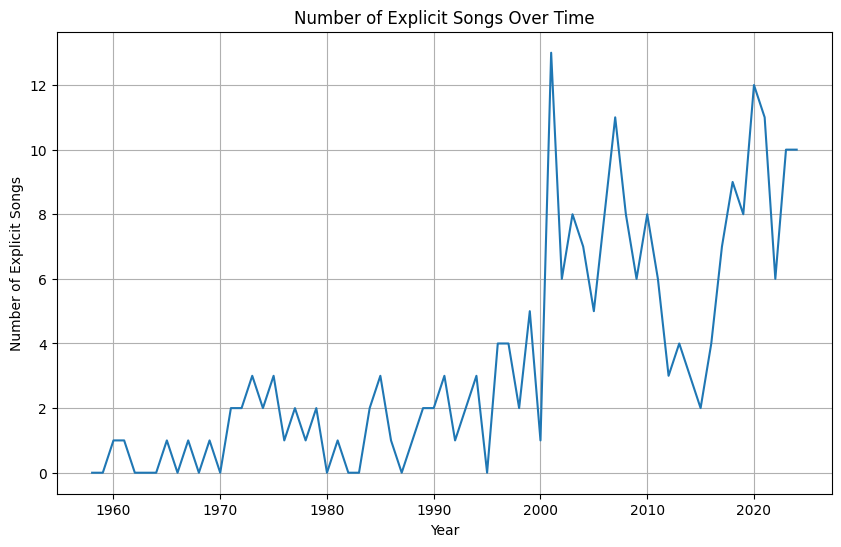

In [45]:
explicit_counts_by_year = df_cleaned.groupby('year')['explicit'].sum()
plt.figure(figsize=(10, 6))
explicit_counts_by_year.plot(kind='line')
plt.title('Number of Explicit Songs Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Explicit Songs')
plt.grid(True)
plt.savefig('explicit_content_overtime.png')
plt.show()